# COS30082: Poject - Facial Recognition with Emotion & Liveness - 104999348 

**Summary**
* In this project, we will develop a complete face recognition attendance system incorporating face verification, anti-spoofing, and emotion detection capabilities. We implemented and compared two different CNN-based approaches for face verification: a supervised classification model using softmax embeddings and a metric-learning model trained with triplet loss to produce discriminative face embeddings. Similarity between face pairs was evaluated using Euclidean distance and cosine similarity, and model performance was assessed through ROC curves and AUC scores.
* Besides, we also develop a user-friendly GUI to support key functionalities including face registration, identity verification, liveness check, and emotion display. Overall, our system demonstrates an end-to-end solution suitable for enterprise-level attendance applications.


**Import some necessary libraries**

In [1]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.8 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=8bf8838813cc2cf62528753954dfdf255a5eb4630a7aece79c638424043591e2
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
from math import ceil

from sklearn.metrics import confusion_matrix
from keras_facenet import FaceNet
from tqdm import tqdm
from tensorflow.keras import datasets, layers, models, Model, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

2025-11-16 18:16:27.165553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763316987.359927      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763316987.412650      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# 1.Load the preprocessing raw dataset

## 1.1: Load the dataset

In [3]:
# --------- define some necessary param ---------- 

# data path
data_path_classification = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data'
data_path_verification = '/kaggle/input/11-785-fall-20-homework-2-part-2/verification_data'

# Defines how many images are processed together in one step during training.
BATCH_SIZE = 32

# Define the image size 
IMG_SIZE = (224, 224)

# Set the seed to ensure the same random choices for whenever running 
SEED = 42

## 1.2: Split dataset

Make the subfolder for each path

In [4]:
# Subfolders
train_dir = os.path.join(data_path_classification, 'train_data')
val_dir = os.path.join(data_path_classification, 'val_data')
test_dir = os.path.join(data_path_classification, 'test_data')

In [5]:
# --------- Load the full datasets ----------
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 380638 files belonging to 4000 classes.


I0000 00:00:1763317192.897098      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 8000 files belonging to 4000 classes.
Found 8000 files belonging to 4000 classes.


In [6]:
print(f"Number of final Train batches: {len(train_ds)}")
print(f"Number of final Validation batches: {len(validation_ds)}")
print(f"Number of final Test batches: {len(test_ds)}")

Number of final Train batches: 11895
Number of final Validation batches: 250
Number of final Test batches: 250


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [8]:
# # --------- Custom Split Function ----------
# def reduce_dataset(dataset, reduction_ratio=0.3, seed=42):
#     dataset_size = len(dataset)
#     reduced_size = int(dataset_size * reduction_ratio)
#     random.seed(seed)
    
#     # Take only reduced_size batches from the dataset
#     indices = random.sample(range(dataset_size), reduced_size)
    
#     # Enumerate the dataset
#     enumerated = dataset.enumerate()
    
#     # Filter only the indices 
#     filtered = enumerated.filter(
#         lambda i, x: tf.reduce_any(tf.equal(i, indices))
#     )
    
#     # Remove the index
#     subset = filtered.map(lambda i, x: x)
    
#     print(f"Reduced dataset from {dataset_size} → {reduced_size} batches")
#     return subset

In [9]:
# # train_ds_reduce = reduce_dataset(train_ds, reduction_ratio=0.7, seed=SEED)

# reduced_size = int(len(train_ds) * 0.5)
# train_ds_reduce = train_ds.take(reduced_size)

# print(f"Number of final Train batches after reduce: {len(train_ds_reduce)}")

## 1.3: Visualization the dataset

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

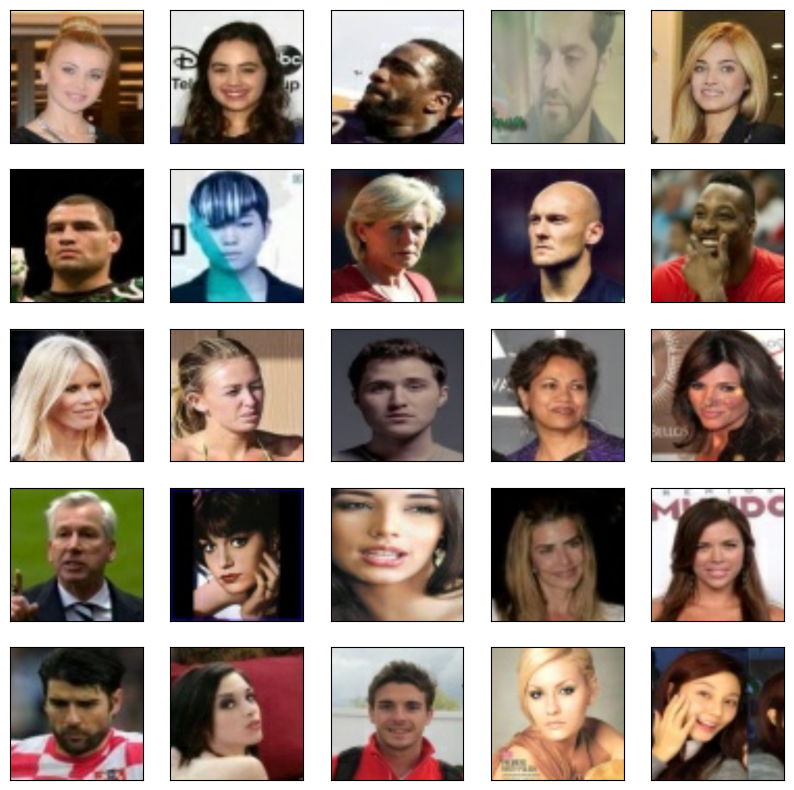

In [10]:
# Get 1 batch safely
images, labels = next(iter(train_ds.take(1)))

# Move to CPU numpy arrays for plotting
images = images.numpy().astype("uint8")
labels = labels.numpy()

# Plot first 25 images in this batch
plt.figure(figsize=(10,10))
for i in range(min(25, len(images))):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()


## 1.4: Data augmentation

In [11]:
def get_data_augmentation(target_size, strength="light"):
    if strength == "light":
        rotation = 0.2
        translation = 0.15
        zoom = 0.1
        contrast = 0.05
        brightness = 0.1
    else:  # strong
        rotation = 0.3
        translation = 0.2
        zoom = 0.2
        contrast = 0.3
        brightness = 0.3

    return tf.keras.Sequential([
        layers.Resizing(int(target_size[0]), int(target_size[1])),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(rotation),
        layers.RandomTranslation(translation, translation),
        layers.RandomZoom(zoom),
        layers.RandomContrast(contrast),
        layers.RandomBrightness(factor=brightness)
    ])

Test the data augementation

In [12]:
data_augmentation = get_data_augmentation((224, 224))

# Load one image from your dataset or local path
image_path_test = "/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/test_data/n000003/0116_02.jpg"

img = tf.keras.utils.load_img(image_path_test, target_size=(64, 64))  
img = tf.keras.utils.img_to_array(img)
img = tf.expand_dims(img, 0)

print("Original image shape:", img.shape)

# Apply augmentation
aug_img = data_augmentation(img)

print("Augmented image shape:", aug_img.shape)

Original image shape: (1, 64, 64, 3)
Augmented image shape: (1, 224, 224, 3)


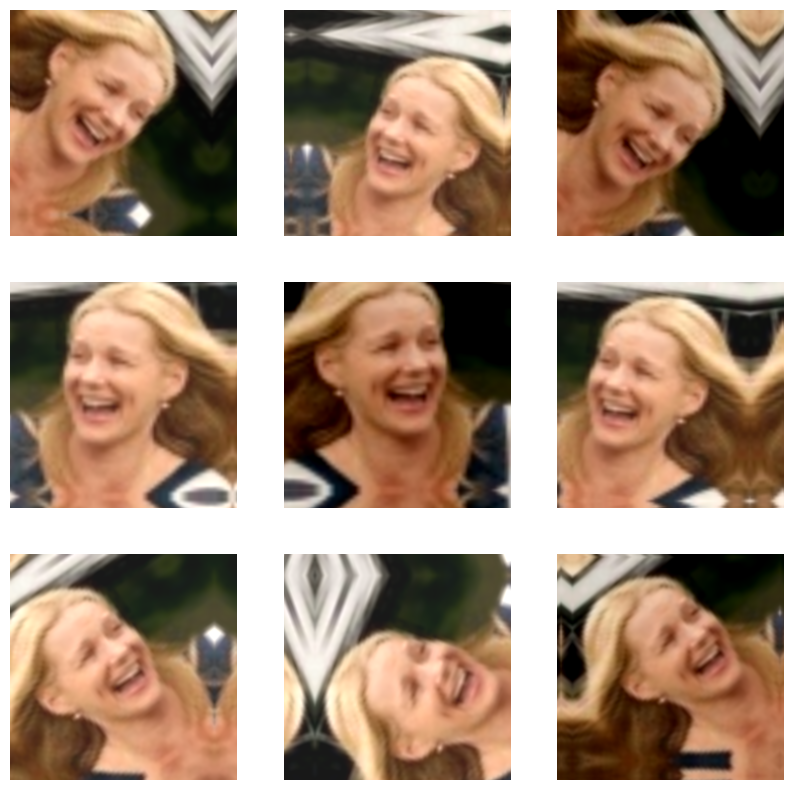

In [13]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    data_augmentation = get_data_augmentation((224, 224))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 1.5: Configure the dataset for performance 


we enable asynchronous data loading, meaning that while the GPU is training on one batch of data, the CPU is already preparing the next batch in the background.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_ds.shuffle(1000).repeat().prefetch(AUTOTUNE)
# train_dataset = train_ds.shuffle(1000).repeat().prefetch(3)

# train_dataset = train_ds_reduce.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

## 1.6 Normalize pixel values

In [15]:
# normalize_rescaling = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255)
# ])

# 2. Metrics Define 

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from tensorflow.keras.preprocessing import image

In [17]:
class FaceVerificationEvaluator:
    def __init__(self, model, model_name, embedding, base_model_configs ,batch_size=32):
        self.model = model
        self.model_name = model_name.lower()
        self.config = base_model_configs
        self.batch_size = batch_size
        self.embed_model = Model(
            inputs=self.model.input,
            outputs=self.model.get_layer(embedding).output
        )

    def load_and_preprocess(self, img_path):
        """Load and preprocess image for model input."""
        target_size = self.config['img_size']
        preprocess = self.config['preprocess']
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess(img_array)
        return img_array

    def extract_embeddings_bulk(self, img_paths, chunk_size = 32):
        embedding_cache = {}
        num_chunks = ceil(len(img_paths) / chunk_size)
    
        print(f"Extracting embeddings for {len(img_paths)} images in {num_chunks} chunks...")
    
        for i in tqdm(range(num_chunks), desc="Processing chunks"):
            chunk_paths = img_paths[i*chunk_size : (i+1)*chunk_size]
            imgs = np.vstack([self.load_and_preprocess(p) for p in chunk_paths])
            embeddings = self.embed_model.predict(imgs, batch_size=self.batch_size, verbose=0)

            # all_embeddings.append(embeddings)
            for p, e in zip(chunk_paths, embeddings):
                embedding_cache[p] = e
        
        return embedding_cache


    @staticmethod
    def compute_similarity(emb1, emb2, metric='cosine'):
        if metric == 'cosine':
            return cosine_similarity([emb1], [emb2])[0][0]
        elif metric == 'euclidean':
            return -euclidean(emb1, emb2)  # negate so higher is better for ROC
        else:
            raise ValueError("metric must be 'cosine' or 'euclidean'")

    @staticmethod
    def plot_roc(y_true, y_scores, title="ROC Curve"):
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(title)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
        return roc_auc

    def evaluate(self, verif_df, limit=None, log_interval=200):
        if limit:
            verif_df = verif_df.head(limit)
            print(f"Limiting to first {limit} pairs for faster test")

        # Cache embeddings
        all_paths = set(verif_df['img1']).union(set(verif_df['img2']))
        embedding_cache = self.extract_embeddings_bulk(list(all_paths))

        y_true, y_scores_cosine, y_scores_euclid = [], [], []

        print(f"\nEvaluating {self.model_name} on {len(verif_df)} pairs...")
        for idx, row in enumerate(verif_df.itertuples(), start=1):
            emb1 = embedding_cache[row.img1]
            emb2 = embedding_cache[row.img2]

            y_true.append(row.label)
            y_scores_cosine.append(self.compute_similarity(emb1, emb2, metric='cosine'))
            y_scores_euclid.append(self.compute_similarity(emb1, emb2, metric='euclidean'))

            if idx % log_interval == 0:
                print(f"Processed {idx}/{len(verif_df)} pairs...")

        auc_cosine = self.plot_roc(y_true, y_scores_cosine, title=f"{self.model_name} - Cosine")
        auc_euclid = self.plot_roc(y_true, y_scores_euclid, title=f"{self.model_name} - Euclidean")

        print(f"\n{self.model_name} | AUC (Cosine): {auc_cosine:.4f} | AUC (Euclidean): {auc_euclid:.4f}")
        return auc_cosine, auc_euclid

# 3. Face Embedding

## 3.1. Classification-based Embedding (Supervised Learning)

### Feature Extraction

In [18]:
IMG_SHAPE_1 = (224,224,3)


# Standard Pretrained CNNs

# ------------ResNet50 model------------------
ResNet50_base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE_1,
                                               include_top=False,
                                               weights='imagenet')


# Face-Specific Pretrained Models
# ------------FaceNet model------------------
embedder = FaceNet()
FaceNet_base_model = embedder.model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

BASE_MODEL_CONFIGS = {
    "resnet50": {
        "preprocess": tf.keras.applications.resnet.preprocess_input,
        "img_size": (224, 224), 
        "stength": "strong"
    },
    "facenet": {
        "preprocess":tf.keras.layers.Lambda(lambda x: (x - 127.5) / 128.0) ,
        "img_size": (160, 160), 
        "stength": "strong"
    },
}

Freeze the convolutional base¶

In [20]:
ResNet50_base_model.trainable = False

In [21]:
# Write the function to set the custom classifier for each different base model

def get_custom_classifier(model_name, x, num_classes): 
    if model_name == "ResNet50":
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        embedding = tf.keras.layers.Dense(256, activation=None, name='cnn_embedding')(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax',  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(embedding)

    else:
        raise ValueError(f"Unknown model_name: {model_name}")

    return outputs

In [22]:
def build_model(base_model, model_name):
    config = BASE_MODEL_CONFIGS[model_name.lower()]

    # set the image size
    image_size = config["img_size"]
    print(f"{model_name} image size: {image_size}")

    # set the custom strength
    strength = config["stength"]
    
    data_augmentation = get_data_augmentation(config["img_size"],strength)
    preprocess = config["preprocess"]


    # define the model architecture
    inputs = tf.keras.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = preprocess(x)
    x = base_model(x, training=False)
    outputs = get_custom_classifier(model_name, x, num_classes=num_classes)
    model = tf.keras.Model(inputs, outputs)

    return model

In [23]:
initial_epochs  = 10
base_learning_rate = 0.001

# # Define the steps per epoch to reduce the time for training
# train_size =  len(train_ds.file_paths)
# steps_per_epoch = ceil(train_size / BATCH_SIZE)

# val_size = len(validation_ds.file_paths)
# validation_steps = ceil(val_size / BATCH_SIZE)

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Train all models
histories = {}
trained_models = {}


base_models = {
    "ResNet50": ResNet50_base_model,
}


for name, base_model  in base_models.items():
    print(f"\n----- Training {name} -----")
    
    model = build_model(base_model, name)

    # summary the model
    model.summary()

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )
    # train_dataset = train_dataset.shuffle(1000).repeat()
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=initial_epochs,
        validation_data=validation_dataset,
        callbacks=[early_stop, reduce_lr]
    )

    histories[name] = history  # Save history for later comparison
    trained_models[name] = model 


----- Training ResNet50 -----
ResNet50 image size: (224, 224)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_21[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 7, 7,      │          0 │ resnet50[0][0]    │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ cast_1[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_embedding       │ (None, 256)       │    131,328 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4000)      │  1,028,000 │ cnn_embedding[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,798,176 (98.41 MB)

 Trainable params: 2,209,440 (8.43 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

Epoch 1/10


I0000 00:00:1763317234.325020      78 cuda_dnn.cc:529] Loaded cuDNN version 90300


11895/11895 ━━━━━━━━━━━━━━━━━━━━ 990s 82ms/step - accuracy: 0.0138 - loss: 7.4543 - val_accuracy: 0.0404 - val_loss: 6.5832 - learning_rate: 0.0010
Epoch 2/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 975s 82ms/step - accuracy: 0.0367 - loss: 6.7920 - val_accuracy: 0.0532 - val_loss: 6.3534 - learning_rate: 0.0010
Epoch 3/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 980s 82ms/step - accuracy: 0.0455 - loss: 6.6140 - val_accuracy: 0.0614 - val_loss: 6.2127 - learning_rate: 0.0010
Epoch 4/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 981s 82ms/step - accuracy: 0.0516 - loss: 6.4992 - val_accuracy: 0.0691 - val_loss: 6.0990 - learning_rate: 0.0010
Epoch 5/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 978s 82ms/step - accuracy: 0.0557 - loss: 6.4268 - val_accuracy: 0.0730 - val_loss: 6.0341 - learning_rate: 0.0010
Epoch 6/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 976s 82ms/step - accuracy: 0.0593 - loss: 6.3731 - val_accuracy: 0.0749 - val_loss: 5.9802 - learning_rate: 0.0010
Epoch 7/10
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 978s 82ms/ste

### Save the model

In [24]:
save_dir = "/kaggle/working/saved_models"
os.makedirs(save_dir, exist_ok=True)

for name, model in trained_models.items():
    # Save in TensorFlow SavedModel format
    feature_model_path = os.path.join(save_dir, f"{name}_feature_extractor.keras")
    model.save(feature_model_path, save_format="tf")
    print(f"Saved feature extractor: {feature_model_path}")


Saved feature extractor: /kaggle/working/saved_models/ResNet50_feature_extractor.keras


### Test models with ROC and AUC

In [25]:
base_path = '/kaggle/input/11-785-fall-20-homework-2-part-2/'
verif_file = '/kaggle/input/11-785-fall-20-homework-2-part-2/verification_pairs_val.txt'

verif_df = pd.read_csv(verif_file, sep=' ', header=None, names=['img1', 'img2', 'label'])
print(verif_df.head())

                             img1                            img2  label
0  verification_data/00041961.jpg  verification_data/00044353.jpg      0
1  verification_data/00007133.jpg  verification_data/00060449.jpg      1
2  verification_data/00041961.jpg  verification_data/00020166.jpg      0
3  verification_data/00013102.jpg  verification_data/00055525.jpg      1
4  verification_data/00002921.jpg  verification_data/00041331.jpg      0


In [26]:
verif_df['img1'] = verif_df['img1'].apply(lambda x: base_path + x)
verif_df['img2'] = verif_df['img2'].apply(lambda x: base_path + x)
print("Number of verification pairs:", len(verif_df))

Number of verification pairs: 8805


Extracting embeddings for 9355 images in 293 chunks...


Processing chunks: 100%|██████████| 293/293 [02:08<00:00,  2.27it/s]



Evaluating resnet50 on 8805 pairs...
Processed 200/8805 pairs...
Processed 400/8805 pairs...
Processed 600/8805 pairs...
Processed 800/8805 pairs...
Processed 1000/8805 pairs...
Processed 1200/8805 pairs...
Processed 1400/8805 pairs...
Processed 1600/8805 pairs...
Processed 1800/8805 pairs...
Processed 2000/8805 pairs...
Processed 2200/8805 pairs...
Processed 2400/8805 pairs...
Processed 2600/8805 pairs...
Processed 2800/8805 pairs...
Processed 3000/8805 pairs...
Processed 3200/8805 pairs...
Processed 3400/8805 pairs...
Processed 3600/8805 pairs...
Processed 3800/8805 pairs...
Processed 4000/8805 pairs...
Processed 4200/8805 pairs...
Processed 4400/8805 pairs...
Processed 4600/8805 pairs...
Processed 4800/8805 pairs...
Processed 5000/8805 pairs...
Processed 5200/8805 pairs...
Processed 5400/8805 pairs...
Processed 5600/8805 pairs...
Processed 5800/8805 pairs...
Processed 6000/8805 pairs...
Processed 6200/8805 pairs...
Processed 6400/8805 pairs...
Processed 6600/8805 pairs...
Processed

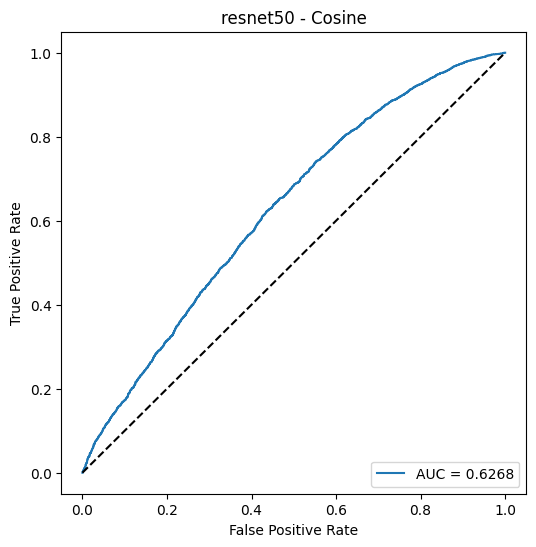

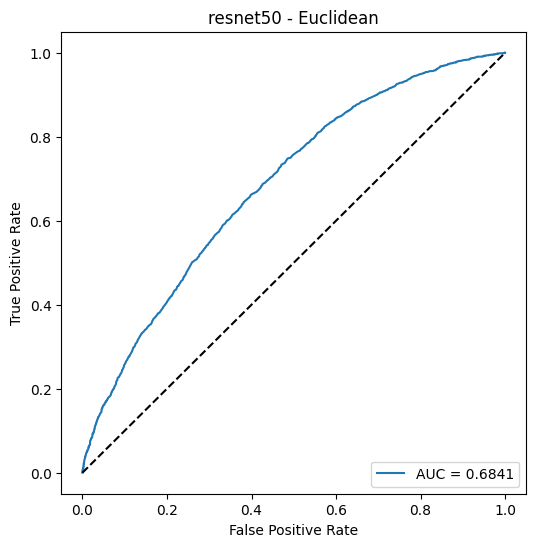


resnet50 | AUC (Cosine): 0.6268 | AUC (Euclidean): 0.6841
ResNet50 | Cosine AUC: 0.6268, Euclidean AUC: 0.6841


In [27]:
embedding_map = {
    "resnet50": "cnn_embedding",
}

for model_name, model in trained_models.items():
    embedding = embedding_map[model_name.lower()]
    evaluator = FaceVerificationEvaluator(model, model_name, embedding, BASE_MODEL_CONFIGS[model_name.lower()])
    auc_cos, auc_eu = evaluator.evaluate(verif_df, limit=None)
    print(f"{model_name} | Cosine AUC: {auc_cos:.4f}, Euclidean AUC: {auc_eu:.4f}")


### Finetuning 

In [28]:
ResNet50_base_model.trainable = True

In [29]:
trained_models

{'ResNet50': <Functional name=functional_3, built=True>}

In [30]:
for name, model in base_models.items():
    print(f"Number of layers in the base model {name}: ", len(model.layers))

    fine_tune_at = int(len(model.layers) * 0.9) 
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
      layer.trainable = False

Number of layers in the base model ResNet50:  175


In [31]:
for name, model in trained_models.items():
    print(f"Number of trainable_variables in the trained model {name}: ", len(model.trainable_variables))

Number of trainable_variables in the trained model ResNet50:  28


In [32]:
finetune_epochs = 12
total_epochs = initial_epochs + finetune_epochs
fine_tuned_models = {}


# Train all models
for name, model in trained_models.items():
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    
    # Compile the model for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n---- Compile and fine-tune {name} model ----")
    
    # Fine-tune from where the feature extraction phase left off
    history_fine = model.fit(
        train_dataset,
        initial_epoch=initial_epochs,   # continue from previous epochs
        epochs=total_epochs,
        validation_data=validation_dataset,
        callbacks=[early_stop, reduce_lr]
    )

    fine_tuned_models[name] = model

    if name in histories:
        for k in history_fine.history.keys():
            histories[name].history[k].extend(history_fine.history[k])
    else:
        histories[name] = history_fine


---- Compile and fine-tune ResNet50 model ----
Epoch 11/22
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 1177s 98ms/step - accuracy: 0.0852 - loss: 5.9922 - val_accuracy: 0.1367 - val_loss: 5.3122 - learning_rate: 1.0000e-05
Epoch 12/22
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 1164s 98ms/step - accuracy: 0.1229 - loss: 5.5210 - val_accuracy: 0.1650 - val_loss: 5.0352 - learning_rate: 1.0000e-05
Epoch 13/22
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 1162s 98ms/step - accuracy: 0.1449 - loss: 5.2677 - val_accuracy: 0.1854 - val_loss: 4.8306 - learning_rate: 1.0000e-05
Epoch 14/22
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 1162s 98ms/step - accuracy: 0.1634 - loss: 5.0793 - val_accuracy: 0.2033 - val_loss: 4.6803 - learning_rate: 1.0000e-05
Epoch 15/22
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 1154s 97ms/step - accuracy: 0.1773 - loss: 4.9344 - val_accuracy: 0.2179 - val_loss: 4.5406 - learning_rate: 1.0000e-05
Epoch 16/22
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 1150s 97ms/step - accuracy: 0.1896 - loss: 4.8098 - val_accuracy: 0.2336 - val_los

In [33]:
# def showPerformance(acc, val_acc, loss, val_loss, name):
#     plt.figure(figsize=(14, 4))

#     # Accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(acc, label='Training Accuracy')
#     plt.plot(val_acc, label='Validation Accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.plot([initial_epochs,initial_epochs],
#           plt.ylim(), label='Start Fine Tuning')
#     plt.xlabel('epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')

#     # Loss
#     plt.subplot(1, 2, 2)
#     plt.plot(loss, label='Training Loss')
#     plt.plot(val_loss, label='Validation Loss')
#     plt.title('Training and Validation Loss')
#     plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Fine Tuning')
#     plt.xlabel('epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')

#     plt.tight_layout()
#     plt.show()


# for name, history in histories.items():
#     print(f"\n Performance for {name} model:")
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     showPerformance(acc, val_acc, loss, val_loss, name)

### Save the models

In [34]:
for name, model in fine_tuned_models.items():
    # Save in TensorFlow SavedModel format
    feature_model_path = os.path.join(save_dir, f"{name}_finetuned.keras")
    model.save(feature_model_path, save_format="tf")
    print(f"Saved finetune: {feature_model_path}")

Saved finetune: /kaggle/working/saved_models/ResNet50_finetuned.keras


### Test models with ROC and AUC

Extracting embeddings for 9355 images in 293 chunks...


Processing chunks: 100%|██████████| 293/293 [01:09<00:00,  4.24it/s]



Evaluating resnet50 on 8805 pairs...
Processed 200/8805 pairs...
Processed 400/8805 pairs...
Processed 600/8805 pairs...
Processed 800/8805 pairs...
Processed 1000/8805 pairs...
Processed 1200/8805 pairs...
Processed 1400/8805 pairs...
Processed 1600/8805 pairs...
Processed 1800/8805 pairs...
Processed 2000/8805 pairs...
Processed 2200/8805 pairs...
Processed 2400/8805 pairs...
Processed 2600/8805 pairs...
Processed 2800/8805 pairs...
Processed 3000/8805 pairs...
Processed 3200/8805 pairs...
Processed 3400/8805 pairs...
Processed 3600/8805 pairs...
Processed 3800/8805 pairs...
Processed 4000/8805 pairs...
Processed 4200/8805 pairs...
Processed 4400/8805 pairs...
Processed 4600/8805 pairs...
Processed 4800/8805 pairs...
Processed 5000/8805 pairs...
Processed 5200/8805 pairs...
Processed 5400/8805 pairs...
Processed 5600/8805 pairs...
Processed 5800/8805 pairs...
Processed 6000/8805 pairs...
Processed 6200/8805 pairs...
Processed 6400/8805 pairs...
Processed 6600/8805 pairs...
Processed

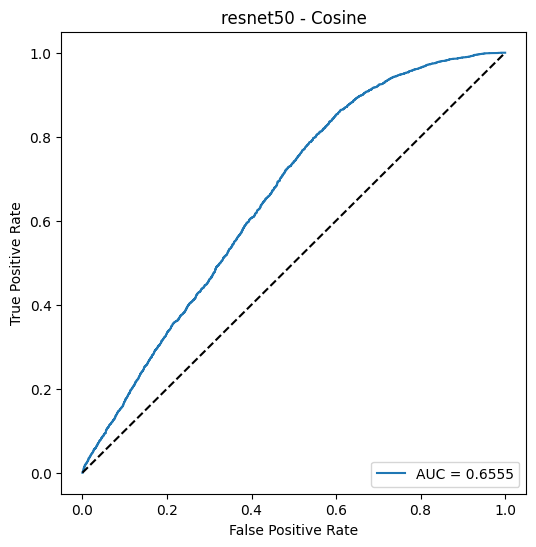

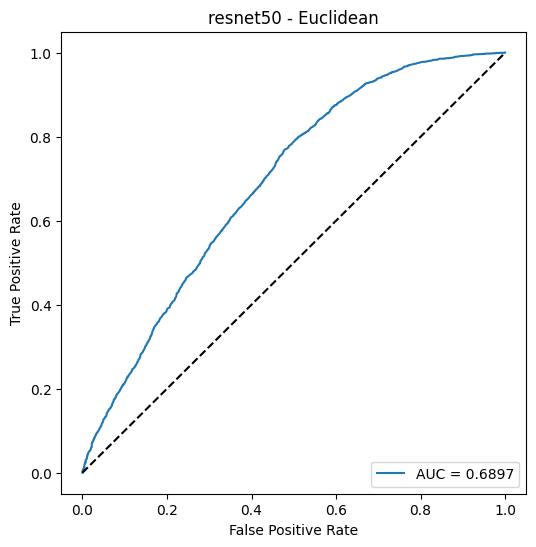


resnet50 | AUC (Cosine): 0.6555 | AUC (Euclidean): 0.6897
ResNet50 | Cosine AUC: 0.6555, Euclidean AUC: 0.6897


In [35]:
for model_name, model in fine_tuned_models.items():
    embedding = embedding_map[model_name.lower()]
    evaluator = FaceVerificationEvaluator(model, model_name, embedding, BASE_MODEL_CONFIGS[model_name.lower()])
    auc_cos, auc_eu = evaluator.evaluate(verif_df, limit=None)
    print(f"{model_name} | Cosine AUC: {auc_cos:.4f}, Euclidean AUC: {auc_eu:.4f}")